# Using RCAEval to Diagnose Code-Level Faults

This notebook demonstrates how RCAEval identifies the root cause service and fine-grained root cause indicators of a code-level fault. In this demonstration, we transform logs to time series and feed them into BARO to diagnose the root cause.

**Bug Description**: We injected a code-level fault, namely **Incorrect parameter values** (as described in [D]), into the `cartservice` of the Online Boutique system. Empirical studies show that **Incorrect parameter values** is one of the five most common faults in real-world projects and that injected faults can realistically simulate real software faults [A,B,C,D].

Specifically, we triggered this code-level fault by using an extremely large number when calling the function `AddItemAsync` in the file `RedisCartStore.cs` (line 54) to add items to a cart, e.g., attempting to add 100000000000 items.

**Symptoms**: After injecting this fault, the `cartservice` became unstable, leading to failures in all its callers. The `front-end` services reported error codes. Resource usage of the `cartservice` spiked, with other services such as `recommendationservice` and `shippingservice` also affected.

**Root cause**: The root cause service is the `cartservice`. The fine-grained root cause indicator is the `stack trace` presented below.

---
```bash
info: Grpc.AspNetCore.Server.ServerCallHandler[7]
      Error status code 'FailedPrecondition' with detail 'Can't access cart storage. System.OverflowException: Value was either too large or too small for an Int32.
         at System.Number.ThrowOverflowException[TInteger]()
         at cartservice.cartstore.RedisCartStore.AddItemAsync(String, String, String) in /app/cartstore/RedisCartStore.cs:line 54' raised.   
```
---
**Step-by-Step: Using RCAEval to Diagnose the Root Cause**:

Below are the steps taken to diagnose this failure:

1. Read available logs.
2. Parse logs into time series and visualize them.
3. Apply BARO [E].


References:
- [A] Pham, et al. "Failure diagnosis for distributed systems using targeted fault injection." In:TPDS’16.
- [B] Andrews, et al. "Is mutation an appropriate tool for testing experiments?." In: ICSE’05.
- [C] Christmansson, et al. "Generation of an error set that emulates software faults based on field data." In: FTCS’96.
- [D] Cotroneo, et al. "How bad can a bug get? an empirical analysis of software failures in the openstack cloud computing platform." In: FSE’19.
- [E] Pham, et al. "BARO: Robust root cause analysis for microservices via multivariate bayesian online change point detection." In: FSE'24.

In [3]:
import pandas as pd 
import numpy as np
import warnings 
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt


# 1. Read available logs

In [41]:
logs = pd.read_csv("data/RE3/RE3-OB/cartservice_f1/2/logs.csv")
ta = 1732279831

# 2. Parse logs into time series
Parse logs into time series and plot them.

In [7]:
logs.head()

,time,timestamp,container_name,message,pod_name,node_name
0,12:38,1732279111001644531,adservice,received ad request (context_words=[kitchen]),adservice-b9bcc6cc9-rb9qn,ip-192-168-6-79.ap-southeast-2.compute.internal
1,12:38,1732279111003879571,frontend,request complete,frontend-588fbcd66b-fjnp2,ip-192-168-83-253.ap-southeast-2.compute.internal
2,12:38,1732279111365545236,frontend,request started,frontend-588fbcd66b-fjnp2,ip-192-168-83-253.ap-southeast-2.compute.internal
3,12:38,1732279111365568125,frontend,setting currency,frontend-588fbcd66b-fjnp2,ip-192-168-83-253.ap-southeast-2.compute.internal
4,12:38,1732279111365587350,frontend,request complete,frontend-588fbcd66b-fjnp2,ip-192-168-83-253.ap-southeast-2.compute.internal


In [33]:
# separate normal logs and stack traces, stack traces has more than 1 line
normal_logs = logs[logs['message'].apply(lambda x: len(x.split("\n")) == 1)]
stack_traces = logs[logs['message'].apply(lambda x: len(x.split("\n")) > 1)]

df_dict = {}
for svc in logs['container_name'].unique():
    svc_logs = logs[logs['container_name'] == svc]
    svc_normal_logs = svc_logs[svc_logs['message'].apply(lambda x: len(x.split("\n")) == 1)]
    svc_stack_traces = svc_logs[svc_logs['message'].apply(lambda x: len(x.split("\n")) > 1)]
    
    svc_normal_logs['timestamp'] = pd.to_datetime(svc_normal_logs['timestamp'])
    svc_stack_traces['timestamp'] = pd.to_datetime(svc_stack_traces['timestamp'])
    svc_normal_logs['timestamp'] = svc_normal_logs['timestamp'].dt.floor('15s')
    svc_stack_traces['timestamp'] = svc_stack_traces['timestamp'].dt.floor('15s')
    
    svc_normal_logs = svc_normal_logs['timestamp'].value_counts().sort_index()
    svc_stack_traces = svc_stack_traces['timestamp'].value_counts().sort_index()
    svc_normal_logs = svc_normal_logs.resample('15s').sum().fillna(0)
    svc_stack_traces = svc_stack_traces.resample('15s').sum().fillna(0)
    
    svc_normal_logs = pd.DataFrame(svc_normal_logs)
    svc_stack_traces = pd.DataFrame(svc_stack_traces)
    
    df_dict[f"{svc}_normal"] = svc_normal_logs
    df_dict[f"{svc}_stack"] = svc_stack_traces

# merge df_dict into 1 df by time
logs_df = pd.DataFrame({'time': df_dict['cartservice_normal'].index})
logs_df = logs_df.set_index('time')
for key in df_dict.keys():
    df = df_dict[key]
    df.columns = [key]
    logs_df = logs_df.join(df, how='outer')
# fill na 
logs_df = logs_df.fillna(0)

# plot, set legend outside of the plot
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots()
# logs_df.plot(ax=ax)
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.show()
# logs_df["cartservice_stack"].plot()

# 4. Apply BARO

In [34]:
from RCAEval.e2e import baro

logs_df.index = logs_df.index.astype(int) // 1000000000

# convert index to 'time' col 
time_col = logs_df.index
logs_df = logs_df.reset_index()
logs_df.insert(0, "time", time_col)
# remove index col
logs_df = logs_df.drop(columns=["index"])
logs_df.head()

,time,adservice_normal,adservice_stack,frontend_normal,frontend_stack,currencyservice_normal,currencyservice_stack,cartservice_normal,cartservice_stack,recommendationservice_normal,...,shippingservice_normal,shippingservice_stack,checkoutservice_normal,checkoutservice_stack,paymentservice_normal,paymentservice_stack,emailservice_normal,emailservice_stack,redis_normal,redis_stack
0,1732279110,35,0.0,192,0.0,223,0.0,55,0.0,37,...,34.0,0.0,9.0,0.0,6.0,0.0,3.0,0.0,0.0,0.0
1,1732279125,51,0.0,262,0.0,264,0.0,75,0.0,53,...,30.0,0.0,3.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0
2,1732279140,43,0.0,258,0.0,259,0.0,79,0.0,59,...,56.0,0.0,9.0,0.0,6.0,0.0,3.0,0.0,0.0,0.0
3,1732279155,44,0.0,243,0.0,246,0.0,76,0.0,59,...,48.0,0.0,6.0,0.0,4.0,0.0,2.0,0.0,5.0,0.0
4,1732279170,51,0.0,303,0.0,305,0.0,93,0.0,66,...,60.0,0.0,12.0,0.0,8.0,0.0,4.0,0.0,0.0,0.0


In [36]:
baro(logs_df, ta)['ranks']

['cartservice_stack',
 'redis_normal',
 'time',
 'checkoutservice_normal',
 'paymentservice_normal',
 'emailservice_normal',
 'paymentservice_stack',
 'adservice_normal',
 'cartservice_normal',
 'frontend_normal',
 'shippingservice_normal',
 'adservice_stack',
 'frontend_stack',
 'currencyservice_normal',
 'currencyservice_stack',
 'recommendationservice_normal',
 'recommendationservice_stack',
 'shippingservice_stack',
 'checkoutservice_stack',
 'emailservice_stack',
 'redis_stack']

<Axes: >

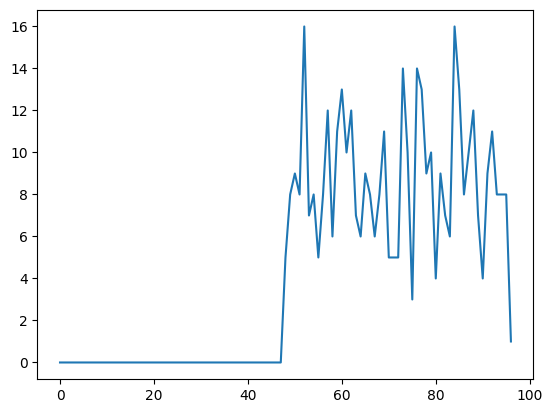

In [43]:
# show `cartservice_stack`
logs_df["cartservice_stack"].plot()

In [44]:
# config pandas to display full text
import pandas as pd
pd.set_option('display.max_colwidth', None)

cart_logs = logs[logs['container_name'] == "cartservice"]
abnormal_logs = cart_logs[cart_logs['timestamp']//1000000000 >= ta]
stack_traces = abnormal_logs[abnormal_logs['message'].apply(lambda x: len(x.split("\n")) > 1)]

# display the stack trace 
print(stack_traces['message'].iloc[10])
    

info: Grpc.AspNetCore.Server.ServerCallHandler[7]
      Error status code 'FailedPrecondition' with detail 'Can't access cart storage. System.OverflowException: Value was either too large or too small for an Int32.
         at System.Number.ThrowOverflowException[TInteger]()
         at System.Number.ThrowOverflowOrFormatException[TChar,TInteger](ParsingStatus, ReadOnlySpan`1)
         at System.Number.ParseBinaryInteger[TChar,TInteger](ReadOnlySpan`1, NumberStyles, NumberFormatInfo)
         at System.Int32.Parse(ReadOnlySpan`1 s, NumberStyles style, IFormatProvider provider)
         at System.Int32.Parse(String s, NumberStyles style, IFormatProvider provider)
         at System.Int32.Parse(String s)
         at cartservice.cartstore.RedisCartStore.AddItemAsync(String, String, String) in /app/cartstore/RedisCartStore.cs:line 54' raised.


## Summary: 

**BARO can rank `cartservice_stack` as the fine-grained root cause, indicating `cartservice` is the root cause services, and the stack traces is the root cause indicator**

## Future works:

Using LLM to diagnose the line of code, faulty function from the stack traces could be very interesting. 